In [1]:
import cv2
import glob
import re
from PIL import Image
import numpy as np

In [2]:
def preprocess(img):
    h, w, c = img.shape
    longest_edge = max(h, w)
    top = 0
    bottom = 0
    left = 0
    right = 0
    if h < longest_edge:
        diff_h = longest_edge - h
        top = diff_h // 2
        bottom = diff_h - top
    elif w < longest_edge:
        diff_w = longest_edge - w
        left = diff_w // 2
        right = diff_w - left
    else:
        pass
    
    img = cv2.copyMakeBorder(img, top, bottom, left, right,
                             cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return img

def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def get_img_path(dir_name:str):
    files = f"{dir_name}/"
    img_path = sorted(glob.glob(str(files+"*.jpg")), key=numericalSort)
    return img_path           

In [19]:
img_path = get_img_path("../../img_data/rectangle/trafficLightImg3")
i=1
for file in img_path:
    img = cv2.imread(file)
    img = preprocess(img)
    img = cv2.resize(img, dsize=(32, 32))
    cv2.imwrite("../../img_data/rectangle/preprocessImg3/"+str(i)+".jpg", img)
    i+=1

In [4]:
import keras
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
import csv
import pandas as pd

Using TensorFlow backend.


In [20]:
preprocess_path = get_img_path("../../img_data/rectangle/preprocessImg3")
x_train_path, x_test_path = train_test_split(preprocess_path, test_size=0.2, shuffle=False)

In [21]:
x_train = np.zeros((len(x_train_path),32*32*3))
for i in range(len(x_train_path)):
    x_train[i] = np.array(Image.open(x_train_path[i])).reshape(1, 32*32*3)
x_train = x_train.reshape(len(x_train_path), 32, 32, 3)

x_test= np.zeros((len(x_test_path),32*32*3))
for i in range(len(x_test_path)):
    x_test[i] = np.array(Image.open(x_test_path[i])).reshape(1, 32*32*3)
x_test = x_test.reshape(len(x_test_path), 32, 32, 3)

df = pd.read_csv("trafficLight_class3.csv", header=0, usecols=['label'])

y_label = np.zeros(df.values.shape[0])
for j in range(df.values.shape[0]):
    y_label[j] = df.values[j]

# label={0:green, 1:red, 2:car, 3:others}
y_train, y_test = train_test_split(y_label, test_size=0.2, shuffle=False)

In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
import os

In [23]:
batch_size = 64
num_classes = 4
epochs = 50

In [24]:
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_datagen.fit(x_train)
train_generator = train_datagen.flow(x_train, Y_train, batch_size=batch_size)

test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen.fit(x_test)
validation_generator = test_datagen.flow(x_test,
                                         Y_test,
                                         batch_size=batch_size,)

data_augumentaion = True
num_predictions = 20
save_dir  = os.path.join(os.getcwd(), 'save_models')
model_name ='trafficLight_classification3.h5'

In [25]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import rmsprop

In [26]:
model = Sequential()
model.add(Conv2D(64, (4,4), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

# model.add(Conv2D(64, (4,4), padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D((2,2)))
model.add(BatchNormalization())

# model.add(Conv2D(128, (4,4), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
opt = keras.optimizers.rmsprop()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [27]:
history = model.fit(x_train,
                    Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, Y_test))

model.save('trafficLight_classification2.h5')
score = model.evaluate(x_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2400 samples, validate on 600 samples
Epoch 1/50
2400/2400 [==============================] - 1s 518us/step - loss: 1.5588 - acc: 0.5675 - val_loss: 0.7140 - val_acc: 0.7467
Epoch 2/50
2400/2400 [==============================] - 0s 60us/step - loss: 0.7750 - acc: 0.6875 - val_loss: 0.5406 - val_acc: 0.8517
Epoch 3/50
2400/2400 [==============================] - 0s 63us/step - loss: 0.6787 - acc: 0.7342 - val_loss: 0.4021 - val_acc: 0.8783
Epoch 4/50
2400/2400 [==============================] - 0s 60us/step - loss: 0.5929 - acc: 0.7875 - val_loss: 0.4403 - val_acc: 0.8550
Epoch 5/50
2400/2400 [==============================] - 0s 53us/step - loss: 0.5020 - acc: 0.8137 - val_loss: 0.3925 - val_acc: 0.8900
Epoch 6/50
2400/2400 [==============================] - 0s 50us/step - loss: 0.4808 - acc: 0.8283 - val_loss: 0.4039 - val_acc: 0.8917
Epoch 7/50
2400/2400 [==============================] - 0s 52us/step - loss: 0.4550 - acc: 0.8429 - val_loss: 0.4916 - val_acc: 0.8483
Epoch 8

In [28]:
import matplotlib.pyplot as plt

def plot_history_lost(hist):
    plt.plot(hist.history['loss'], label='loss for training')
    plt.plot(hist.history['val_loss'], label='loss for validation')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()
    
def plot_history_acc(hist):
    plt.plot(hist.history['acc'], label='accuracy for validation')
    plt.plot(hist.history['val_acc'], label='accuracy for validation')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acuuracy')
    plt.ylim([0,1])
    plt.show()

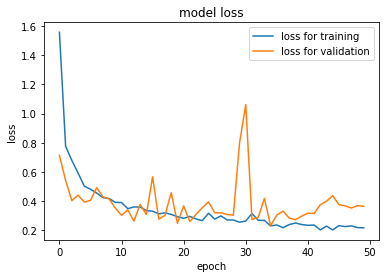

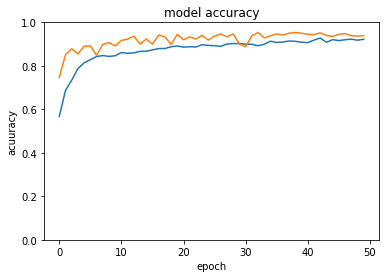

In [29]:
plot_history_lost(history)
plot_history_acc(history)